# Assignment 6

In this assignment, we'll finally work with some nonconjugate models. I will also introduce you to reparameterization techniques.

## Instructions

Please complete this Jupyter notebook and **don't** convert it to a `.py` file. Upload this notebook, along with any `.stan` files and any data sets as a `zip` file to Gradescope. 

Your work will be manually graded by our TA. There is no autograder for this assignment. For free response work, feel free to add a markdown cell and type in there. Try to keep the preexisting structure as much as possible, and to be organized and label which cells correspond with which questions.

This jupyter notebook should look somewhat like a report. It should be easy to follow for someone who understands how to write the code and interpret your results!





### Problem 1: Stocks (revisited with `stan`)

Previously we took unconstrained multivariate data, and we used a multivariate normal distribution for it. That is, suppose each length $k$ row is called $y_i$ and that each row is independent. Then

$$
L(y_1, \ldots, y_N \mid \theta) = \prod_{j=1}^N L(y_j \mid \theta)
$$

where $\theta = (\mu, \Sigma)$ and 

$$
 y_k \mid \mu, \Sigma \sim \text{Normal}(\mu, \Sigma).
$$

We used the **Normal Inverse Wishart** prior because it's the conjugate prior. That involves choosing $\mu_0, \kappa_0, \Lambda_0, \nu_0$ Now I'll introduce a different prior that is very popular for `stan` users that is simpler to choose and sometimes produces a posterior that is easier to sample from.



In [1]:
import pandas as pd
import numpy as np
import os
from cmdstanpy import CmdStanModel
import matplotlib.pyplot as plt

1.

Download the data `stocks.csv` and assign it to a `pandas` `DataFrame` called `adj_prices`. Be sure to set the date as the index.

Calculate percent returns (scaled by $100$) and call the resulting `DataFrame` `rets`. After understanding where they come from, be sure to remove any `NaN`s.

In [2]:
rets = pd.read_csv('stocks.csv', index_col = 'Date').pct_change().iloc[1:,]*100

2.

Use the same prior as you did for homework 4 and simulate from the prior predictive distribution. Instead of doing it with your own handwritten function `sim_data()`, use `stan` to accomplish this. Produce appropriate visualizations and comment on them. 

NB: If I might suggest a small tweak to the demo code--don't hardcode any prior hyperparams. This will make it easier to change your prior later on!

In [178]:
# build model
model_code = os.path.join('.', 'multinorm_invwish.stan')
model = CmdStanModel(stan_file=model_code)

15:54:42 - cmdstanpy - INFO - compiling stan file /bml24/06/multinorm_invwish.stan to exe file /bml24/06/multinorm_invwish
15:55:12 - cmdstanpy - INFO - compiled model executable: /bml24/06/multinorm_invwish


15:58:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:58:55 - cmdstanpy - INFO - CmdStan done processing.
15:58:55 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = inf, but random variable[2,1] = inf (in 'multinorm_invwish.stan', line 17, column 2 to column 57)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = inf, but random variable[2,1] = inf (in 'multinorm_invwish.stan', line 17, column 2 to column 57)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = inf, but random variable[2,1] = inf (in 'multinorm_invwish.stan', line 17, column 2 to column 57)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = inf, but random variable[2,1] = inf (in 'multinorm_invwish.stan', line 17, column 2 to column 57)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = inf, but random variable[2,1] = inf (in 'multinorm_in


mu[1]         1.00013
mu[2]         1.00008
Sigma[1,1]    1.00151
Sigma[1,2]    1.00181
Sigma[2,1]    1.00181
Sigma[2,2]    1.00173
Name: R_hat, dtype: float64


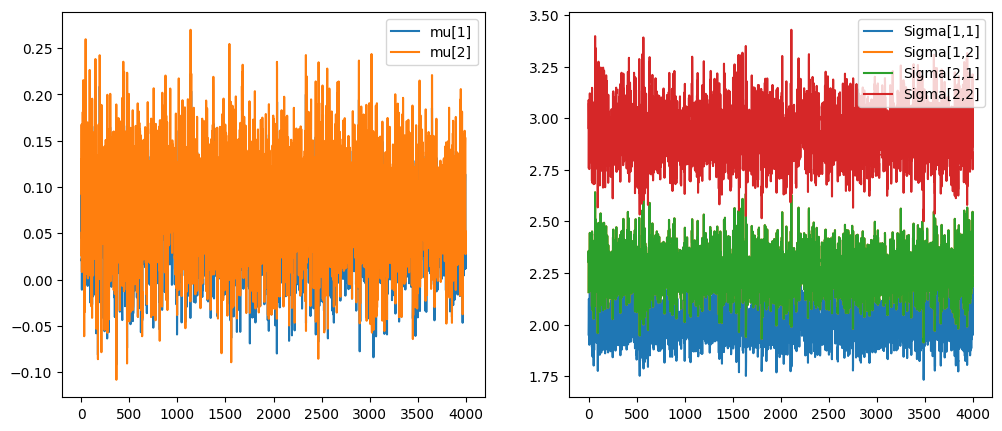

In [188]:
# sample from model
returns_data = {'n' : rets.shape[0], 
                'd' : rets.shape[1],
                'y': rets.values.transpose(),
                'diag_cov' : [1/2,1/3],
                'prior_mu' : np.array([0, 0]),
                'prior_wish' : 10}

# define a helper function
def get_diagnostics(fit):
    print(fit.summary()['R_hat'].iloc[1:7,])
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
    ax[0].plot(fit.draws_pd()[['mu[1]','mu[2]']])
    ax[0].legend(['mu[1]','mu[2]'])
    ax[1].plot(fit.draws_pd()[['Sigma[1,1]','Sigma[1,2]', 'Sigma[2,1]', 'Sigma[2,2]']])
    ax[1].legend(['Sigma[1,1]','Sigma[1,2]', 'Sigma[2,1]', 'Sigma[2,2]'])
    plt.show()

# get diagnostics
fit = model.sample(returns_data)
get_diagnostics(fit)

> Diagnostics all look good - R_hat close to 1 and fuzzy caterpillars!

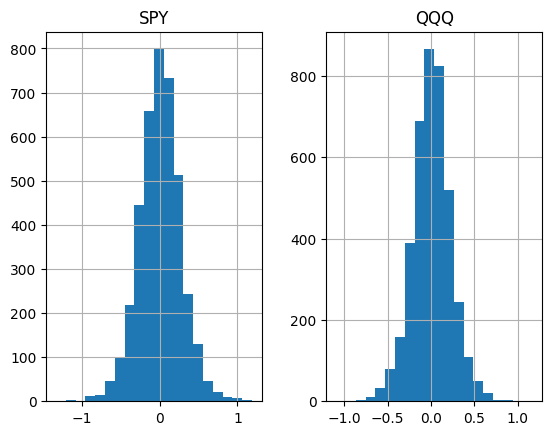

In [189]:
# retrieve samples from prior PD
columns1 = [x for x in fit.draws_pd().columns if 'prior_pd[1' in x]
columns2 = [x for x in fit.draws_pd().columns if 'prior_pd[2' in x]
prior_pd = fit.draws_pd()[columns1 + columns2]
prior_pd.columns = ['SPY', 'QQQ']
prior_pd.hist(bins = 20)
plt.show()

> Both stocks seem pretty normally distributed around zero, which is what I would expect because my prior mean is (0, 0). The histograms seem a little peaky - I might expect stocks to range to +/- 2-4 percent, not just 1.

3.

Simulate parameters from the posterior using `stan`. Describe how to treat diagnostics, and then interpret and display your results. Take note of any interesting findings regarding parameter estimates. 

Try to use [`hist2d()`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.hist2d.html) to visualize the posteriof of $\mu$.
For visualizing the covariance matrix samples, just plot the three unique values on overlaid histograms.
                                                   

           mean    median
mu[1]  0.054429  0.054441
mu[2]  0.080865  0.080164


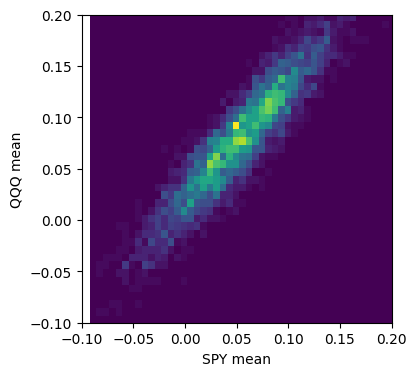

In [203]:
# samples from posterior
plt.figure(figsize = (4, 4))
plt.hist2d(fit.draws_pd()['mu[1]'], 
           fit.draws_pd()['mu[2]'], 
           bins = 50)
plt.xlabel('SPY mean')
plt.ylabel('QQQ mean')
plt.xlim(-.1, 0.2)
plt.ylim(-.1, 0.2)
print(pd.DataFrame({'mean' : fit.draws_pd()[['mu[1]', 'mu[2]']].mean(),
                    'median' : fit.draws_pd()[['mu[1]', 'mu[2]']].median()}))
plt.show()

> It looks like my prior mean of (0, 0) was a bit of an underestimate, with the posterior giving its highest density around (0.05, 0.1). We can see that QQQ has a higher variance and both means are normally distributed.

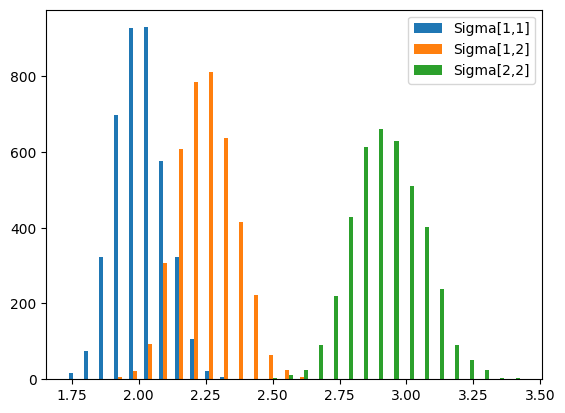

In [191]:
plt.hist(fit.draws_pd()[['Sigma[1,1]','Sigma[1,2]','Sigma[2,2]']],
         label = ['Sigma[1,1]','Sigma[1,2]','Sigma[2,2]'], 
         bins = 30)
plt.legend()
plt.show()

> The covariance matrix would be about [[2, 2.2], [2.2, 2.8]], meaning that the second stock has a higher variance.

4.

Take your chosen portfolio weights from homework 4 and simulate portfolio returns from the posterior predictive distribution. Are they "good?" Visualize them in a variety of interesting ways!

How do these returns compare with "backtested" returns? In other words, how do these simulated returns compare with taking the same weight vector, and seeing how they did retrospectively on "real" (not simulated) data. 

Keep in mind that retrospective analysis is not always indicative of future results!

                mean    median         sum
y_tilde[1]  0.108793  0.137218  109.336647
y_tilde[2] -0.047823 -0.044278  -48.061892


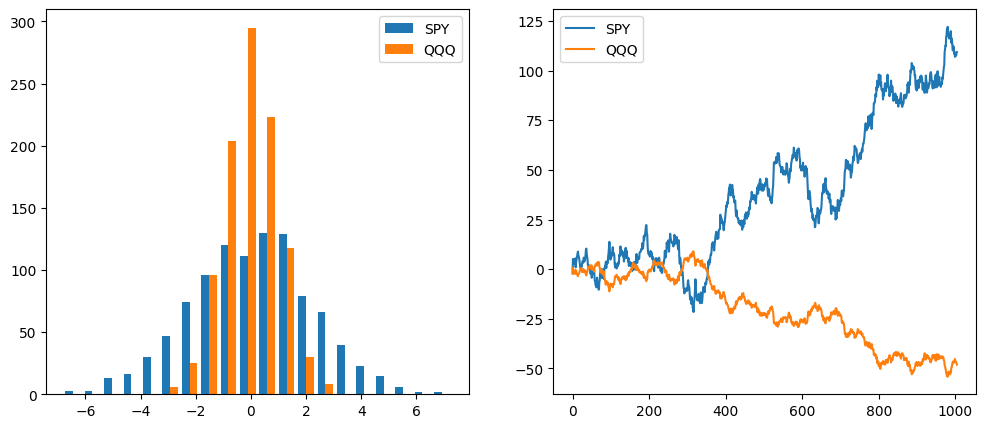

In [252]:
portfolio_weights = [ 1.57091423, -0.57091423]

# retreive samples from post PD
columns1 = [x for x in fit.draws_pd().columns if 'y_tilde[1' in x]
columns2 = [x for x in fit.draws_pd().columns if 'y_tilde[2' in x]
stock1_rets = fit.draws_pd()[columns1] * portfolio_weights[0]
stock2_rets = fit.draws_pd()[columns2] * portfolio_weights[1]

post_pd = pd.concat([stock1_rets, stock2_rets], axis = 1).iloc[0:len(rets),]

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
ax[0].hist(post_pd, bins = 20)
ax[0].legend(['SPY', 'QQQ'])
ax[1].plot(post_pd.cumsum())
ax[1].legend(['SPY', 'QQQ'])
print(pd.DataFrame({'mean' : post_pd.mean(), 
                    'median' : post_pd.median(), 
                    'sum' : post_pd.sum()}))
plt.show()

> As expected, most of the returns cluster around zero. SPY's average is positive while QQQ averaged negative. Comparison between mean and median show a right skew for SPY and a slight left skew for QQQ. Even though the distribution of the mean from the posterior was higher for QQQ, it also had a higher variance, which in this set of simulated data ended up leading to a negative trend. The timeseries plot shows the results of the sums played out over time. If I had invested in this portfolio on day zero I would be up about $84 on day 1005.

         mean    median        sum
SPY  0.085365  0.132240  85.791492
QQQ -0.046146 -0.072587 -46.376519


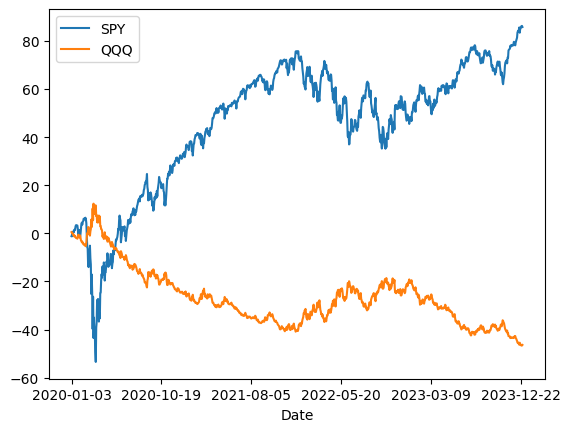

In [195]:
print(pd.DataFrame({'mean' : weighted_rets.mean(), 
                    'median' : weighted_rets.median(), 
                    'sum' : weighted_rets.sum()}))
weighted_rets = pd.concat([rets.iloc[:,0] * portfolio_weights[0],
                          rets.iloc[:,1] * portfolio_weights[1]],
                         axis = 1)
weighted_rets.cumsum().plot()
plt.show()

> The past real data matches the fake data quite well, actually. If I had invested in this portfolio on Jan 03, 2020, I would be up about $39 on December 12, 2022.

5.

Simulate parameters from the posterior after making adjustments to your prior. Do not feel obligated to re-do all of the same work you did in the previous problem. Instead, discuss (qualitatively) how sensitive your posterior appears to be to the choices you made on your prior. 

18:51:26 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

18:51:43 - cmdstanpy - INFO - CmdStan done processing.
18:51:43 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'multinorm_invwish.stan', line 17, column 2 to column 57)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'multinorm_invwish.stan', line 17, column 2 to column 57)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'multinorm_invwish.stan', line 17, column 2 to column 57)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'multinorm_invwish.stan', line 17, column 2 to column 57)
	Exception: inv_wishart_lpdf: random variable is not symmetric. random variable[1,2] = -nan, but random variable[2,1] = -nan (in 'mu


mu[1]         1.00058
mu[2]         1.00049
Sigma[1,1]    1.00042
Sigma[1,2]    1.00068
Sigma[2,1]    1.00068
Sigma[2,2]    1.00074
Name: R_hat, dtype: float64


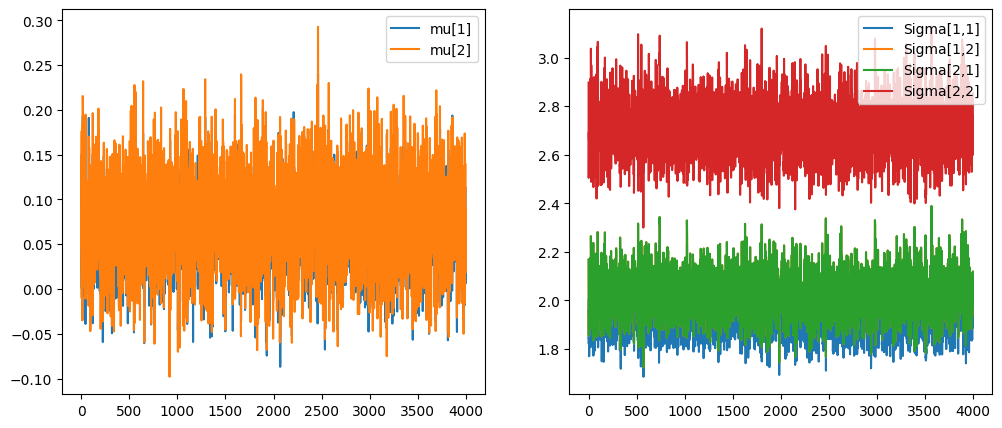

In [204]:
# sample from model
returns_data = {'n' : rets.shape[0], 
                'd' : rets.shape[1],
                'y': rets.values.transpose(),
                'diag_cov' : [3/4,1/6],
                'prior_mu' : np.array([10, -5]),
                'prior_wish' : 100}
fit = model.sample(returns_data)
get_diagnostics(fit)

> The parameters all converge around the same points. Sigma was the most affected, with each element of the matrix being a little lower, but I was pretty extreme with my inverse-wishart hyperparameter. Overall, I would say the model is not super sensitive to hyperparameter changes. I suppose this is because we have a decent amount of data, over 1000 points.

6.

Now choose any prior you want for the unknown mean and covariance matrix parameters. You can do anything you want as long as you

 - produce `stan` code that runs without error, and
 - use the LKJ distribution for the correlation matrix. 

Be sure to complete all the above steps:

 - simulate from the prior predictive distribution as a check on the prior;
 - simulate parameters from the posterior (check diagnostics, visualize and report); and
 - simulate from the posterior predictive distribution in the same way you did earlier.

In [231]:
# build model
model_code = os.path.join('.', 'fun.stan')
model = CmdStanModel(stan_file=model_code)

19:12:56 - cmdstanpy - INFO - compiling stan file /bml24/06/fun.stan to exe file /bml24/06/fun
19:13:23 - cmdstanpy - INFO - compiled model executable: /bml24/06/fun


In [255]:
# sample from model
returns_data = {'n' : rets.shape[0], 
                'd' : rets.shape[1],
                'y': rets.values.transpose(),
                #'eta' : 1,
                'prior_mu' : np.array([0, 0])}
fit = model.sample(returns_data)

19:30:50 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

19:31:06 - cmdstanpy - INFO - CmdStan done processing.
19:31:06 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'fun.stan', line 21, column 2 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'fun.stan', line 21, column 2 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'fun.stan', line 21, column 2 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'fun.stan', line 21, column 2 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'fun.stan', line 21, column 2 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'fun.stan', line 21, column 2 to column 33)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'fun.st

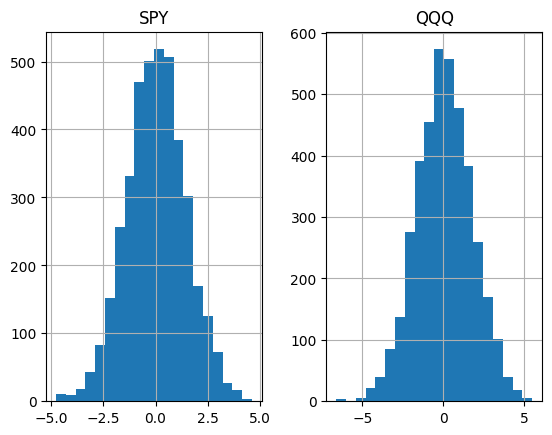

In [256]:
# sample from prior PD
columns1 = [x for x in fit.draws_pd().columns if 'prior_pd[1' in x]
columns2 = [x for x in fit.draws_pd().columns if 'prior_pd[2' in x]
prior_pd = fit.draws_pd()[columns1 + columns2]
prior_pd.columns = ['SPY', 'QQQ']
prior_pd.hist(bins = 20)
plt.show()

> The prior PD looks like it makes sense because the data are clustered around 0 and spread to around +/- 5.

mu[1]           1.00192
mu[2]           1.00179
L_Omega[1,1]        NaN
L_Omega[1,2]        NaN
L_Omega[2,1]    1.00273
L_Omega[2,2]    1.00281
Name: R_hat, dtype: float64


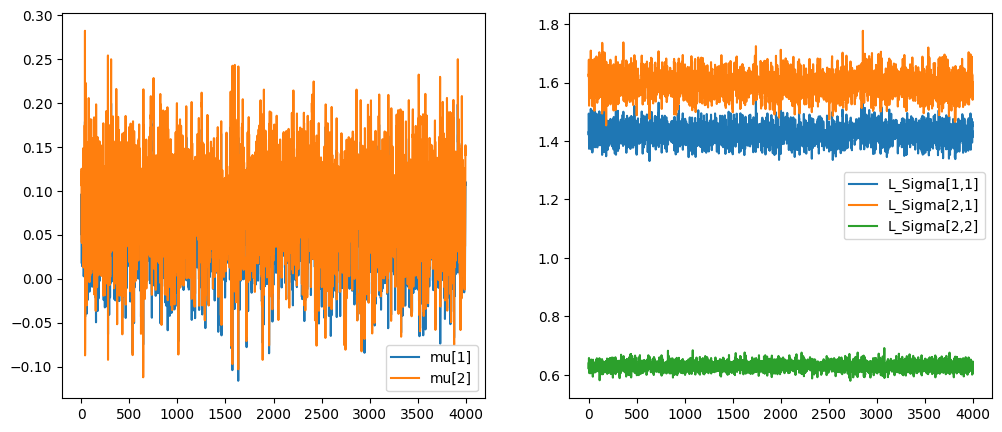

In [257]:
# diagnostics
print(fit.summary()['R_hat'].iloc[1:7,])
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
ax[0].plot(fit.draws_pd()[['mu[1]','mu[2]']])
ax[0].legend(['mu[1]','mu[2]'])
ax[1].plot(fit.draws_pd()[['L_Sigma[1,1]', 'L_Sigma[2,1]', 'L_Sigma[2,2]']])
ax[1].legend(['L_Sigma[1,1]', 'L_Sigma[2,1]', 'L_Sigma[2,2]'])

> The diagnostics look mostly good (close to 1 and fuzzy caterpillars), although I'm not sure why two o fthe Omegas have no R_hat value??

                mean    median         sum
y_tilde[1]  0.112989  0.218623  113.553887
y_tilde[2] -0.051226 -0.068781  -51.482103


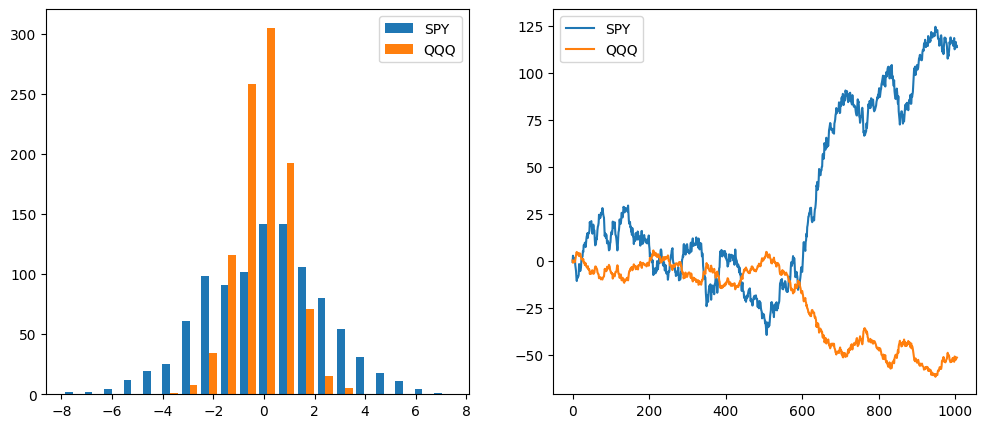

In [258]:
# retreive samples from post PD
columns1 = [x for x in fit.draws_pd().columns if 'y_tilde[1' in x]
columns2 = [x for x in fit.draws_pd().columns if 'y_tilde[2' in x]
stock1_rets = fit.draws_pd()[columns1] * portfolio_weights[0]
stock2_rets = fit.draws_pd()[columns2] * portfolio_weights[1]

post_pd = pd.concat([stock1_rets, stock2_rets], axis = 1).iloc[0:len(rets),]

fix, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 5))
ax[0].hist(post_pd, bins = 20)
ax[0].legend(['SPY', 'QQQ'])
ax[1].plot(post_pd.cumsum())
ax[1].legend(['SPY', 'QQQ'])
print(pd.DataFrame({'mean' : post_pd.mean(), 
                    'median' : post_pd.median(), 
                    'sum' : post_pd.sum()}))
plt.show()

> The output from the posterior PD looks about the same, when accounting for some randomness in sampling. Based on this model, if I invested in that portfolio I would be up about $62 in 1005 days.